# PREDICTING VANCOUVER WEATHER PROJECT REPORT

## Introduction

Weather forecasting first began due to early civilizations observing recurring astronomical and meteorological events in order to monitor seasonal changes. As techniques and technology developed over time, people started using data collected using more and more sophisticated equipment, such as satellites, weather balloons, radars, and so on. These massive datasets were then used to make weather predictions based on past and present data in order to get the most likely outcome.
Weather forecasting is based on an educated guess and is not always accurate. As mentioned, these guesses are based on meteorological data collected in the past. Our project mimics this technique, at a less massive scale, as we aim to predict hourly Vancouver weather using classification based on a dataset found online.
The dataset we are using for our analysis is the hourly weather data recorded in Vancouver (on visualcrossing.com) between 31st December 2020, and 31st December 2022. This dataset contains information such as the hourly temperature, humidity levels, windspeed, precipitation cover, sea level pressure, dew, and many other such meteorological categories. It also includes the simple hourly weather type in the form of picking an icon to show whether it is a clear day, raining, cloudy, and so on. This weather type icon gives the outside conditions in the most concise manner, and therefore is the focus of our project. Vancouver is known for raining a lot throughout the year, therefore it is important to know what the weather looks like outside to stay ahead of the curve.
The icon type column has observations of 7 levels, rain, snow, cloudy, clear-night, clear-day, partly-cloudy-night, partly-cloudy-day: this is the classification we aim to predict. We have decided to use this dataset to reasonably predict the weather type on any given hour based on other meteorological factors. Therefore, our question is, what is the type of weather expected on a certain hour in Vancouver, given only the temperature, humidity, cloud cover, sea level pressure? These four factors are used because they are key in determining weather (National Geographic). Our only disparity with our factors chosen compared to what National Geographic says is that we removed precipitation as a factor in order to make the classification model more applicable and wind speed as it did not particularly affect the results.




## Methods

We will use the temperature (Celsius), humidity (g/m^3), cloud cover (%), and sea level pressure in order to determine the expected weather.To accomplish this, we will be using a k-nearest neighbor classifier algorithm. We will first load in the data from the visualcrossing.com and clean the data to get only the predictors and classes that we need. Then we split the data into training and testing sets so that we can find the accuracy of our classifier once we finish. we will be using cross validation to help us find the optimal K value. After find the K value, we can begin our classification using a workflow. Finally, we will scope the accuracy of our classifier as well as provide insights using a confusion matrix.



First, we will load in the necesarry libraries

In [12]:
library(repr)
library(tidyverse)
library(tidymodels)

We will now read our data from the web

In [69]:
weather_data <- read_csv("https://raw.githubusercontent.com/DaffyDiamond/DSCI-100-Group-30/main/data/vancouver_hourly.csv")
head(weather_data, 5)
'Table 1'

Rows: 17544 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (5): name, preciptype, conditions, icon, stations
dbl  (18): temp, feelslike, dew, humidity, precip, precipprob, snow, snowdep...
dttm  (1): datetime

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,⋯,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
vancouver,2020-12-31 00:00:00,5.9,3.0,5.3,95.97,1.376,100,rain,0,⋯,1005.7,84.6,13,0,NA,0,NA,"Rain, Partially cloudy",rain,"71608099999,CWWA,71211099999,71784099999,71892099999,71042099999"
vancouver,2020-12-31 01:00:00,5.7,2.9,5.0,95.13,0.191,100,rain,0,⋯,1006.3,100.0,12,0,NA,0,NA,"Rain, Overcast",rain,"71608099999,CWWA,71211099999,71784099999,71892099999,71042099999"
vancouver,2020-12-31 02:00:00,5.8,3.5,4.9,93.72,0.606,100,rain,0,⋯,1007.4,71.2,16,0,NA,0,NA,"Rain, Partially cloudy",rain,"71608099999,CWWA,71211099999,71784099999,71892099999,71042099999"
vancouver,2020-12-31 03:00:00,5.7,3.7,4.8,94.11,0.108,100,rain,0,⋯,1008.5,80.7,24,0,NA,0,NA,"Rain, Partially cloudy",rain,"71608099999,CWWA,71211099999,71784099999,71892099999,71042099999"
vancouver,2020-12-31 04:00:00,5.5,3.5,5.1,96.73,2.166,100,rain,0,⋯,1009.6,100.0,6,0,NA,0,NA,"Rain, Overcast",rain,"CWWA,71211099999,71775099999,71784099999,71892099999,71042099999"


[1] "Table 1"

Next we clean the data by removing columns and rows that are unnecesarry to our project

In [68]:
# selected out variables that are irrelivant to our predictions
weather_cleaned <- weather_data |>
    select(datetime, temp, feelslike, humidity, sealevelpressure, cloudcover, icon) |>
    rename(weather = icon) |>
# wind has been filtered out due to being statistically insignificant
    filter(!(weather == "wind"))

head(weather_cleaned, 5)
'Table 2'

datetime,temp,feelslike,humidity,sealevelpressure,cloudcover,weather
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2020-12-31 00:00:00,5.9,3.0,95.97,1005.7,84.6,rain
2020-12-31 01:00:00,5.7,2.9,95.13,1006.3,100.0,rain
2020-12-31 02:00:00,5.8,3.5,93.72,1007.4,71.2,rain
2020-12-31 03:00:00,5.7,3.7,94.11,1008.5,80.7,rain
2020-12-31 04:00:00,5.5,3.5,96.73,1009.6,100.0,rain


[1] "Table 2"

We are now ready to split the data into training and testing to prepare for classification, a seed is used so results can be replicated.

In [41]:
set.seed(1234)

weather_split <- initial_split(weather_cleaned, prop = 0.75, strata = weather)
weather_training <- training(weather_split)
weather_testing <- testing(weather_split)

ggpairs can be used to give us a general idea of the relationships in between the predictors

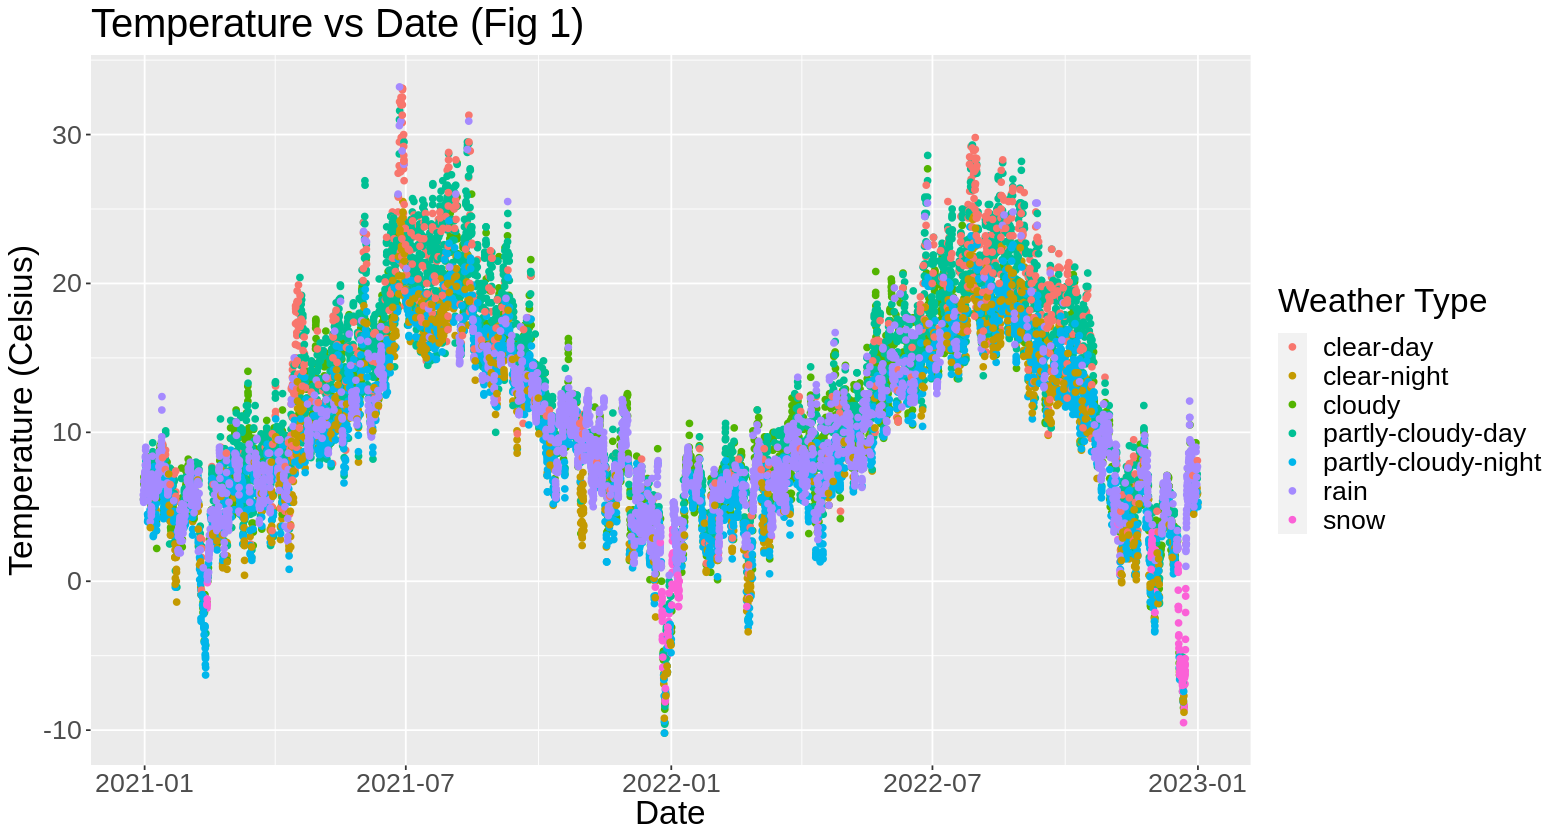

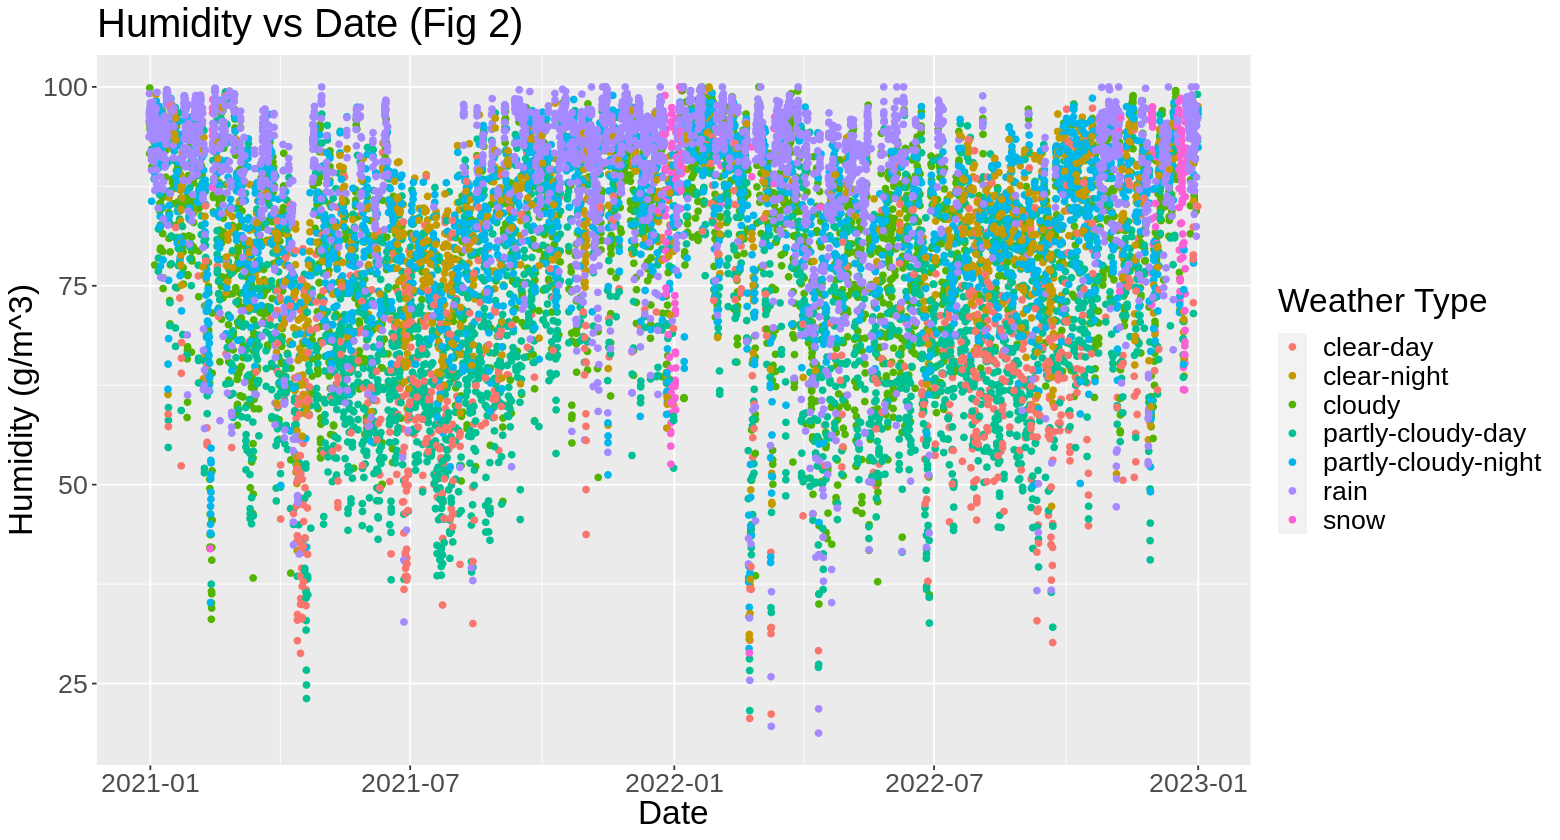

Warning message:
“Removed 1 rows containing missing values (geom_point).”


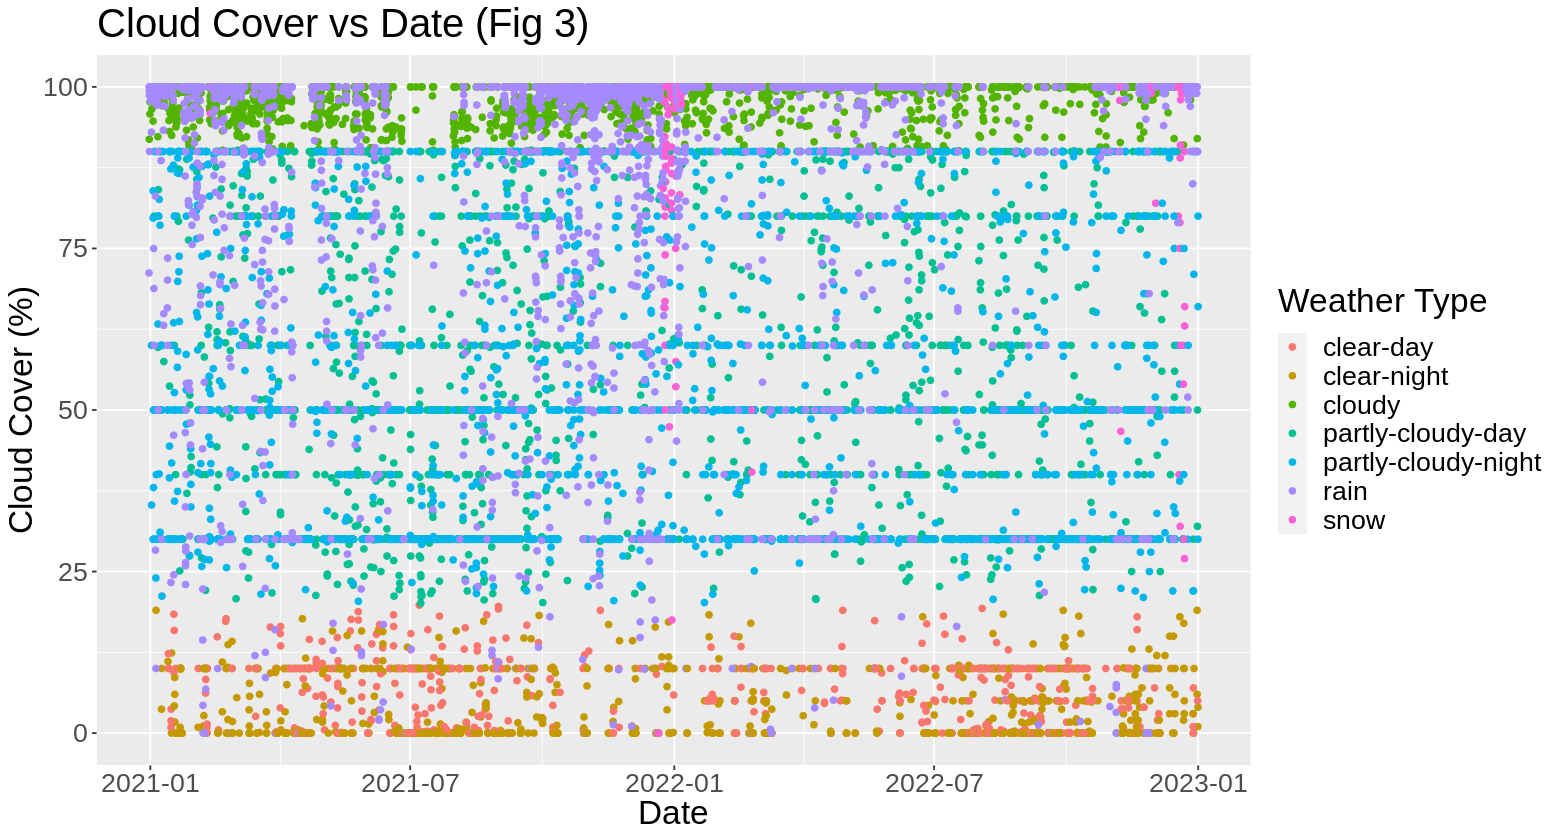

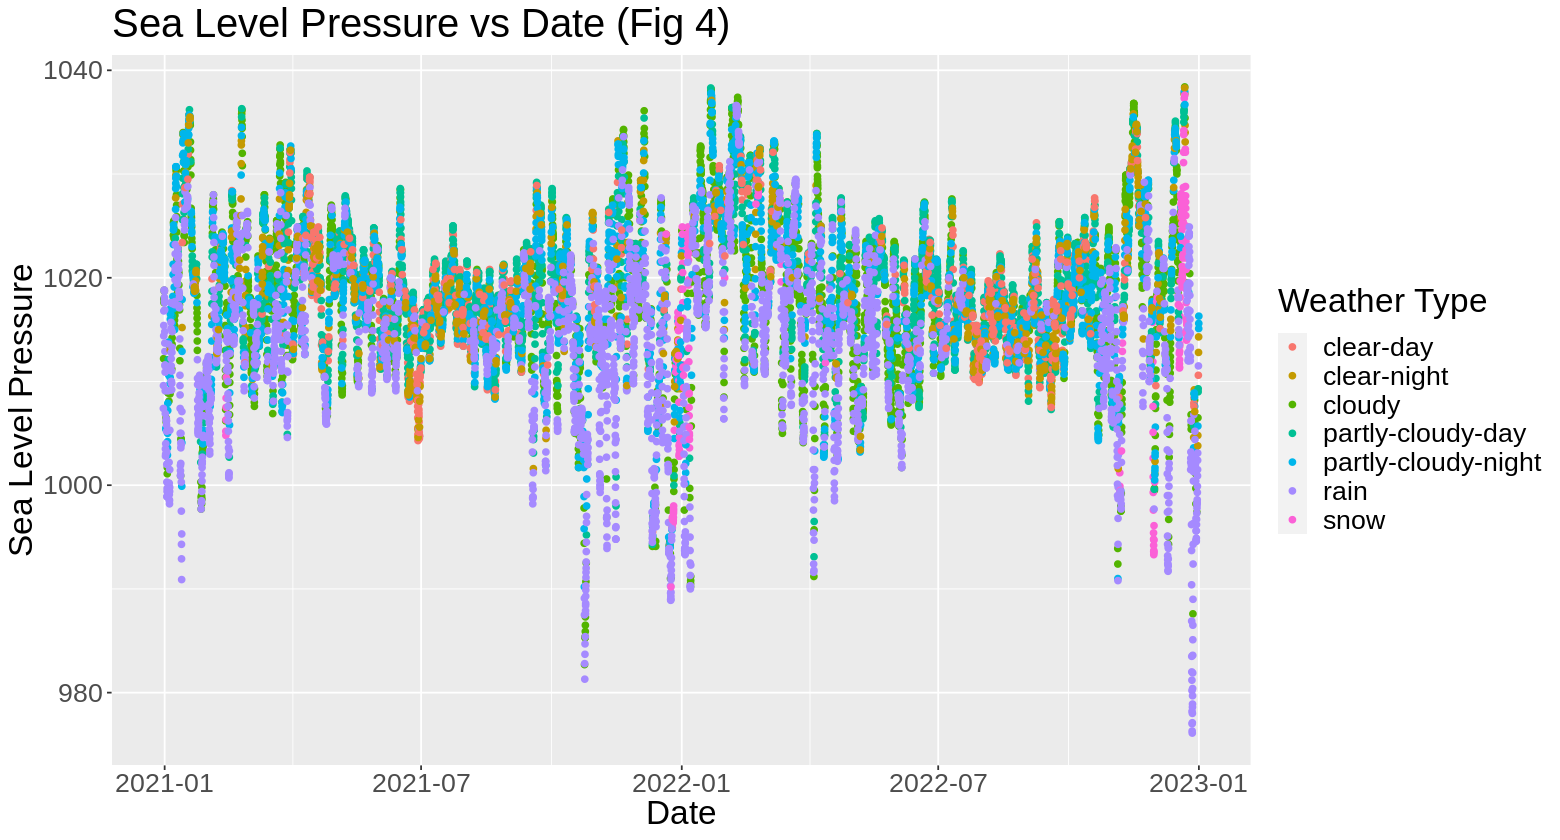

In [75]:
options(repr.plot.width = 13, repr.plot.height = 7)

temperature_plot <- weather_training |>
    ggplot(aes(x=datetime, y=temp)) +
    geom_point(aes(color=weather)) +
    labs(x="Date", y="Temperature (Celsius)", color="Weather Type") +
    theme(text = element_text(size=20)) +
    ggtitle("Temperature vs Date (Fig 1)")

humidity_plot <- weather_training |>
    ggplot(aes(x=datetime, y=humidity)) +
    geom_point(aes(color=weather)) +
    labs(x="Date", y="Humidity (g/m^3)", color="Weather Type") +
    theme(text = element_text(size=20)) + 
    ggtitle("Humidity vs Date (Fig 2)")

cloud_plot <- weather_training |>
    ggplot(aes(x=datetime, y=cloudcover)) +
    geom_point(aes(color=weather)) +
    labs(x="Date", y="Cloud Cover (%)", color="Weather Type") +
    theme(text = element_text(size=20)) +
    ggtitle("Cloud Cover vs Date (Fig 3)")

pressure_plot <- weather_training |>
    ggplot(aes(x=datetime, y=sealevelpressure)) +
    geom_point(aes(color=weather)) +
    labs(x="Date", y="Sea Level Pressure", color="Weather Type") +
    theme(text = element_text(size=20)) +
    ggtitle("Sea Level Pressure vs Date (Fig 4)")




temperature_plot
humidity_plot
cloud_plot
pressure_plot

We will now take a look at the preportions of our data

In [70]:
weather_amount <- weather_training |>
    group_by(weather) |>
    summarize(n())
weather_amount
'Table 3'

weather,n()
<chr>,<int>
clear-day,908
clear-night,1190
cloudy,2834
partly-cloudy-day,2890
partly-cloudy-night,2218
rain,2879
snow,233


[1] "Table 3"

the proportions of the data appears to be quite unblanced, this means we will have to scale and balance the data in the recipe

In [44]:
weather_recipe <- recipe( weather ~ temp + feelslike + humidity + sealevelpressure + cloudcover, data = weather_training) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors()) 

before we start the classification, we must first design the specification, ktune must be used to find the optimal k value.

In [45]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
      set_engine("kknn") |>
      set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


To find the optimal k value, we will be using 10 fold cross validation to ensure greater accuracy 

In [46]:
weather_vfold <- vfold_cv(weather_training, v = 5, strata = weather)

we will now create the resample workflow to help us find the ideal k value

In [54]:
set.seed(4321)
gridvals <- tibble(neighbors = seq(from = 1, to = 50, by = 1))
weather_k_results <- workflow() |>
      add_recipe(weather_recipe) |>
      add_model(knn_tune) |>
      tune_grid(resamples = weather_vfold, grid = gridvals) |>
      collect_metrics()
weather_k_results


x Fold3: preprocessor 1/1, model 1/1 (predictions):
  Error in `mutate()`:
  ! Problem while computing `.row = orig_rows`.
  ✖ `.row` must be size 2629 or 1, not 2630.



neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.6611872,4,0.004170585,Preprocessor1_Model01
1,roc_auc,hand_till,0.8090087,4,0.003600268,Preprocessor1_Model01
2,accuracy,multiclass,0.6611872,4,0.004170585,Preprocessor1_Model02
2,roc_auc,hand_till,0.8716969,4,0.002389814,Preprocessor1_Model02
3,accuracy,multiclass,0.6885575,4,0.002829435,Preprocessor1_Model03
3,roc_auc,hand_till,0.8972152,4,0.002711134,Preprocessor1_Model03
4,accuracy,multiclass,0.6917900,4,0.003026807,Preprocessor1_Model04
4,roc_auc,hand_till,0.9105153,4,0.002777488,Preprocessor1_Model04
5,accuracy,multiclass,0.6982518,4,0.002856988,Preprocessor1_Model05


'Table 4'

after collecting the results, we will use a graph to help us visualize the ideal k value

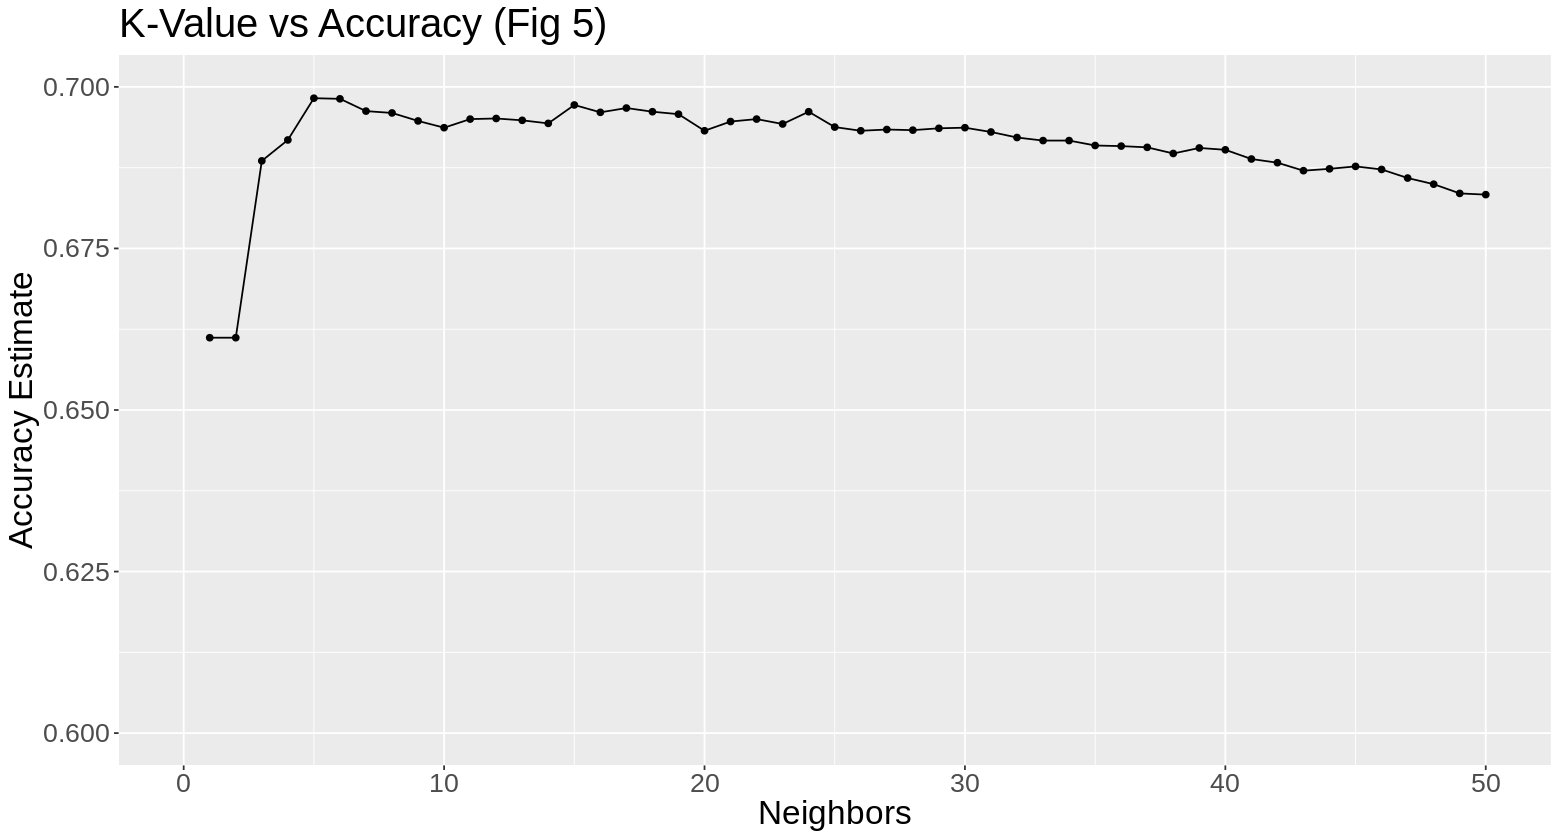

In [79]:
accuracies <- weather_k_results|> 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      ggtitle("K-Value vs Accuracy (Fig 5)")+
      theme(text = element_text(size=20)) +
      scale_x_continuous(limits = c(0, 50, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.6, 0.7)) # adjusting the y-axis

accuracy_versus_k
# your code here

Now we will use this information to find the ideal k value

In [57]:
kval <- accuracies |>
    arrange(desc(mean)) |>
    head(1)|>
    select(neighbors)|>
    pull()
    
kval

[1] 5

now that we have the ideal k value, we can create the proper knn specification for the classification

In [60]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kval) |>
      set_engine("kknn") |>
      set_mode("classification")

now the we have the specification, we can start to put the whole thing together

In [61]:
set.seed(2222)
weather_fit <- workflow() |>
      add_recipe(weather_recipe) |>
      add_model(knn_spec) |>
      fit(data = weather_training)
weather_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(5,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3021063
Best kernel: rectangular
Best k: 5

with our workflow ready to go, we can now dothe classification

In [71]:
set.seed(111) # DO NOT REMOVE

weather_test_predictions <- predict(weather_fit, weather_testing) |>
      bind_cols(weather_testing)|>
      mutate(weather = as.factor(weather))
head(weather_test_predictions, 5)
'Table 5'

.pred_class,datetime,temp,feelslike,humidity,sealevelpressure,cloudcover,weather
<fct>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
rain,2020-12-31 00:00:00,5.9,3.0,95.97,1005.7,84.6,rain
rain,2020-12-31 01:00:00,5.7,2.9,95.13,1006.3,100.0,rain
rain,2020-12-31 03:00:00,5.7,3.7,94.11,1008.5,80.7,rain
rain,2020-12-31 05:00:00,5.5,5.5,95.33,1011.0,92.0,rain
rain,2020-12-31 07:00:00,5.0,5.0,97.06,1013.1,100.0,cloudy


[1] "Table 5"

now that we have a set of prediction for our testing set, we can now use the metric function to asses
the accuracy of our classifier

In [72]:
waether_prediction_accuracy <- weather_test_predictions |>
        metrics(truth = weather, estimate = .pred_class)             
waether_prediction_accuracy
'Table 6'

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.6871865
kap,multiclass,0.6168284


[1] "Table 6"

to get a better scope of the accuracy of our classifier, we shall create a confusion matrix

In [82]:
set.seed(3333)
weather_mat <- weather_test_predictions |> 
      conf_mat(truth = weather, estimate = .pred_class)
weather_mat
"Table 7"

                     Truth
Prediction            clear-day clear-night cloudy partly-cloudy-day
  clear-day                 200          51      0                 0
  clear-night               118         356      0                 0
  cloudy                      0           0    751                71
  partly-cloudy-day           4           0     15               635
  partly-cloudy-night         1           2      1               218
  rain                        4           5    183                44
  snow                        0           0      8                 0
                     Truth
Prediction            partly-cloudy-night rain snow
  clear-day                             0    7    0
  clear-night                           0   15    1
  cloudy                               35  201    4
  partly-cloudy-day                   156   64    2
  partly-cloudy-night                 452   87    3
  rain                                 56  578    8
  snow                        

[1] "Table 7"

looking at the confusion matrix, our classifier has an accuracy of roughly 69 percent

## Discussion


The expectation was to be able to reasonably predict the type of weather on a given hour in Vancouver, British Columbia. We believe that although weather can be unpredictable, if some other data indicators are given it may be possible to develop a model for predicting the general weather type for a given hour. Overall, roughly 70% of accuracy was discovered, which means most of the answers of the questions were positive. However, as mentioned earlier, the major  flaw of our project lies in the data not being balance; for instance, in a span of two years, there were few days where snowfall occurred in Vancouver. The impact of the model being mostly successful means that it could be useful in summarizing the precipitation type for an hour using only certain indicators. It can act as a redundant tool or even a general model that can be scaled to let people know the general weather, which can be useful in implementing a weather app for example. This will lead to future questions of how localized the model will be and how feasible it would be for other locations.

## References

Visual Crossing Corporation. “Historical Weather Data for Vancouver.” Historical Weather 
    <br> &emsp; Data for Vancouver | Visual Crossing, 
    <br> &emsp; www.visualcrossing.com/weather-history/vancouver/metric/2021-01-01/2022-12-31. </br>
Warrilow, Chrissy. “Students Ask: How Do Meteorologists Predict the Weather?” Georgia 
    <br> &emsp;   Public Broadcasting, 15 Feb. 2012, 
    <br> &emsp;  www.gpb.org/blogs/talking-storm/2012/02/15/students-ask-how-do-meteorologists-pr
    <br> &emsp; edict-the-weather. </br>
“Weather Forecasting through the Ages.” NASA Earth Observatory, NASA, 25 Feb. 2002, 
    <br> &emsp; earthobservatory.nasa.gov/features/WxForecasting/wx2.php#:~:text=The%20art%20
    <br> &emsp; of%20weather%20forecasting,seasonal%20changes%20in%20the%20weather. </br>
Weather. National Geographic. (n.d.). Retrieved from 
    <br> &emsp; https://education.nationalgeographic.org/resource/weather/
